<a href="https://colab.research.google.com/github/bruaba/mask_detection/blob/main/Resnet_Projet_Mask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
# -*- coding: utf-8 -*-
"""
Created on Sun Nov 29 18:40:11 2020

@author: cheikh
"""
#libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random as rand
import keras
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings
from PIL import Image
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras import Sequential
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
#from keras_radam import RAdam
from imutils import paths
from bs4 import BeautifulSoup

In [15]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))

In [16]:
def generate_box(obj):  
    xmin = int(float(obj.find('xmin').text))
    ymin = int(float(obj.find('ymin').text))
    xmax = int(float(obj.find('xmax').text))
    ymax = int(float(obj.find('ymax').text))
    
    return [xmin, ymin, xmax, ymax]

#This function will give label assciated with each label and convert them to numbers
def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2
#    elif obj.find('name').text == "without_mask":
#        return 3
    return 0

#Using in this main function we parse the annotations file and get the objects out from them
# Also we use the above two functions here 
def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
            
        boxes=np.array(boxes)
        labels=np.array(labels)

        img_id = np.array(image_id)
    # Annotation is in dictionary format
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return (target,num_objs)

In [17]:
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks (1)")
#!ls


IMG_SIZE = 224
CHANNELS = 3
N_LABELS= 3

In [18]:


imgs = list(sorted(os.listdir("MaskTrainDataset/JPEGImages/")))
labels = list(sorted(os.listdir("MaskTrainDataset/Annotations/")))
#nombre d'images et de labels
print(len(imgs))
print(len(labels))

2655
2655


In [19]:
# Here we use the above functions and save results in lists
targets=[]#store coordinates
numobjs=[]#stores number of faces in each image
#run the loop for number of images we have

i=0
for dirname, _, filenames in os.walk('MaskTrainDataset/Annotations/'):
    for filename in filenames:
        target, numobj = generate_target(i, os.path.join(dirname, filename))
        targets.append(target)
        numobjs.append(numobj)
        i+=1



In [20]:
i=0
face_images=[]
face_labels=[]


for dirname, _, filenames in os.walk('MaskTrainDataset/JPEGImages/'):
    for filename in filenames:
        img_path = os.path.join(dirname, filename)
        img = cv2.imread(img_path)
        for j in range(numobjs[i]):
            locs = (targets[i]['boxes'][j])
            img1 = img[int(locs[1]):int(locs[3]), int(locs[0]):int(locs[2])]       
            try:
                img1 = cv2.resize(img1, (IMG_SIZE, IMG_SIZE))
                img1 = img_to_array(img1)
                img1 = preprocess_input(img1)
                face_images.append(img1)
                face_labels.append(targets[i]['labels'][j])
            except cv2.error:
                continue
            
        i+=1
face_images= np.array(face_images, dtype="float32")
face_labels = np.array(face_labels)


In [21]:

print(len(face_labels))
print(len(face_images))

5735
5735


In [22]:
unique, counts = np.unique(face_labels, return_counts=True)
print(dict(zip(unique, counts)))

{0: 1319, 1: 3988, 2: 428}


In [23]:
#Encode the labels in one hot encode form

#c'est pour transformer les données non numerique en numerique
#ici les labels
#https://stackoverrun.com/fr/q/12291556

lb = LabelEncoder()
train_labels = lb.fit_transform(face_labels)
train_labels = to_categorical(train_labels)
print(train_labels)

[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]


In [31]:
#divide data into training and testing sets
(trainX, testX, trainY, testY) = train_test_split(face_images, train_labels,
    test_size=0.20, stratify=train_labels, random_state=42)


In [25]:
# construct the training image generator for data augmentation
"""
La classe ImageDataGenerator garantit que le modèle reçoit de nouvelles variations des images à chaque époque. 
Mais il ne renvoie que les images transformées et ne les ajoute pas au corpus original d'images. 
Si c'était effectivement le cas, alors le modèle verrait les images originales plusieurs fois, ce qui sur-adapterait certainement notre modèle.

Un autre avantage d'ImageDataGenerator est qu'il nécessite une moindre utilisation de la mémoire. 
En effet, sans utiliser cette classe, nous chargeons toutes les images en même temps. Mais en l'utilisant, nous chargeons les images par lots, ce qui économise beaucoup de mémoire.
"""
#https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
  vertical_flip = True,
	fill_mode="nearest")

In [80]:
feature_extractor_layer = ResNet50V2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(IMG_SIZE,IMG_SIZE,CHANNELS)))

feature_extractor_layer.trainable = False


model = Sequential([
    feature_extractor_layer,
    Flatten(name="flatten"),
    Dropout(0.5),
    Dense(128, activation='relu', name='hidden_layer'),
    Dropout(0.5),
    Dense(N_LABELS, activation='sigmoid', name='output')
])


In [ ]:
#Free some space.I did this tep as the notebook was running out of space while training
#del targets,face_images,face_labels

In [48]:
LR = 1e-5 # Keep it small when transfer learning
EPOCHS = 20
BS = 32

In [81]:
model.compile(
  optimizer=Adam(learning_rate=LR),
  loss="binary_crossentropy",
  metrics=["accuracy"])


In [83]:
import time
start = time.time()
# train the head of the network
print("[INFO] training head...")

H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
  steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),

	epochs=EPOCHS
  )

print('\nTraining took {}'.format((time.time()-start)))

[INFO] training head...
Epoch 1/30
35/35 [==============================] - 47s 1s/step - loss: 0.5385 - accuracy: 0.6673 - val_loss: 0.4994 - val_accuracy: 0.6922
Epoch 2/30
35/35 [==============================] - 47s 1s/step - loss: 0.5201 - accuracy: 0.6735 - val_loss: 0.4936 - val_accuracy: 0.6922
Epoch 3/30
35/35 [==============================] - 47s 1s/step - loss: 0.5114 - accuracy: 0.6776 - val_loss: 0.4912 - val_accuracy: 0.6922
Epoch 4/30
35/35 [==============================] - 47s 1s/step - loss: 0.5049 - accuracy: 0.6814 - val_loss: 0.4910 - val_accuracy: 0.6931
Epoch 5/30
35/35 [==============================] - 47s 1s/step - loss: 0.4956 - accuracy: 0.6836 - val_loss: 0.4896 - val_accuracy: 0.6914
Epoch 6/30
35/35 [==============================] - 47s 1s/step - loss: 0.4978 - accuracy: 0.6836 - val_loss: 0.4890 - val_accuracy: 0.6922
Epoch 7/30
35/35 [==============================] - 47s 1s/step - loss: 0.4972 - accuracy: 0.6834 - val_loss: 0.4891 - val_accuracy: 0.6

[INFO] evaluating network...
[[0.26697218 0.631082   0.06848075]
 [0.09849625 0.8631059  0.02096519]
 [0.26602843 0.7090401  0.04143847]
 ...
 [0.15437093 0.7794755  0.01366145]
 [0.33874178 0.5707995  0.16171515]
 [0.20250745 0.67666    0.06580724]]
              precision    recall  f1-score   support

           0       0.50      0.01      0.02       264
           1       0.70      1.00      0.82       797
           2       0.60      0.03      0.07        86

    accuracy                           0.70      1147
   macro avg       0.60      0.35      0.30      1147
weighted avg       0.65      0.70      0.58      1147

36/36 [==============================] - 3s 85ms/step - loss: 0.4891 - accuracy: 0.6975
[0.4890788495540619, 0.6974716782569885]


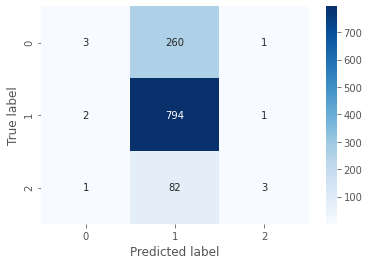

In [84]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

print(predIdxs)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs))

"""
from tensorflow.python.keras.metrics import Metric
k = 4

#avg_prec = Metric.average_precision_at_k(labels, predIdxs, k)

#print(avg_prec)

"""
import seaborn as sns

eval = model.evaluate(testX, testY)

print(eval)

test_Y = np.argmax(testY, axis=1)
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(test_Y, predIdxs), annot=True, fmt='g', cmap=plt.cm.Blues)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()



In [85]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
from datetime import datetime
now = datetime.now()
dt_string = now.strftime("%Y_%m_%d_%H_%M_%S")
dt_string = "mask_detector_Adam_" + dt_string
print(dt_string)
model.save("Model/"+ dt_string + ".h5")


[INFO] saving mask detector model...
mask_detector_Adam_2021_01_26_21_19_35


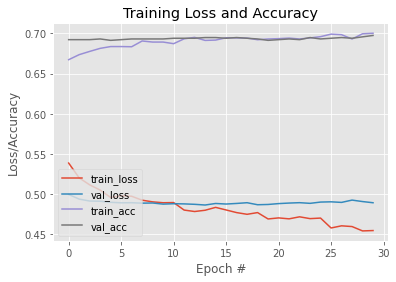

In [86]:
# plot the training loss and accuracy


N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("Model/"+ dt_string+".png")
plt.show()